In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, precision_recall_curve, auc
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import joblib
import warnings
warnings.filterwarnings('ignore')

sns.set()
sns.set_palette("viridis")


In [137]:
print("Loading dataset...")
df = pd.read_csv('creditcard.csv')

df.fillna(0, inplace=True)

scaler = StandardScaler()
df['Amount_scaled'] = scaler.fit_transform(df[['Amount']])
df['Time_scaled'] = scaler.fit_transform(df[['Time']])
df.drop(['Time', 'Amount'], axis=1, inplace=True)

joblib.dump(scaler, 'scaler.pkl')

X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("\nApplying SMOTE...")
smote = SMOTE(random_state=42,k_neighbors = 1)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

Loading dataset...

Applying SMOTE...


In [141]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,Amount_scaled,Time_scaled
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.0,0.335536,-1.687738
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0.0,-0.272718,-1.687738
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0.0,1.283705,-1.685521
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.0,0.227405,-1.685521
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0.0,0.005887,-1.683303


In [138]:
def build_autoencoder(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(32, activation='relu'),
        Dense(64, activation='relu'),
        Dense(input_dim, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

def build_classifier(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model

print("\nTraining Autoencoder on normal transactions...")
normal_train = X_train_res[y_train_res == 0]
autoencoder = build_autoencoder(X_train_res.shape[1])
autoencoder.fit(normal_train, normal_train, epochs=30, batch_size=256, validation_split=0.2, verbose=1, callbacks=[EarlyStopping(patience=5, restore_best_weights=True)])

print("\nTraining Fraud Classifier...")
classifier = build_classifier(X_train_res.shape[1])
classifier.fit(X_train_res, y_train_res, epochs=40, batch_size=512, validation_split=0.2, verbose=1, callbacks=[EarlyStopping(patience=7, restore_best_weights=True)])


Training Autoencoder on normal transactions...
Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 1.0076 - val_loss: 0.9570
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.1785 - val_loss: 0.9457
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.1349 - val_loss: 0.9294
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.9742 - val_loss: 0.9048
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.0070 - val_loss: 0.8702
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1.0688 - val_loss: 0.8277
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.8710 - val_loss: 0.7837
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.9865 - val_loss: 0.7492
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.9579 - val_loss: 0.7288
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.7362 - val_loss: 0.7177
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.7806 - val_loss: 0.7090
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 


Evaluating on test set...
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Autoencoder Reconstruction-based Results:
              precision    recall  f1-score   support

         0.0       1.00      0.95      0.97       398
         1.0       0.00      0.00      0.00         0

    accuracy                           0.95       398
   macro avg       0.50      0.47      0.49       398
weighted avg       1.00      0.95      0.97       398

PR-AUC: 0.0

Neural Network Classifier Results:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       398
         1.0       0.00      0.00      0.00         0

    accuracy                           1.00       398
   macro avg       0.50      0.50      0.50       398
weighted avg       1.00      1.00      1.00       398

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
ROC-AUC: nan
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
PR-AUC: 0.0
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


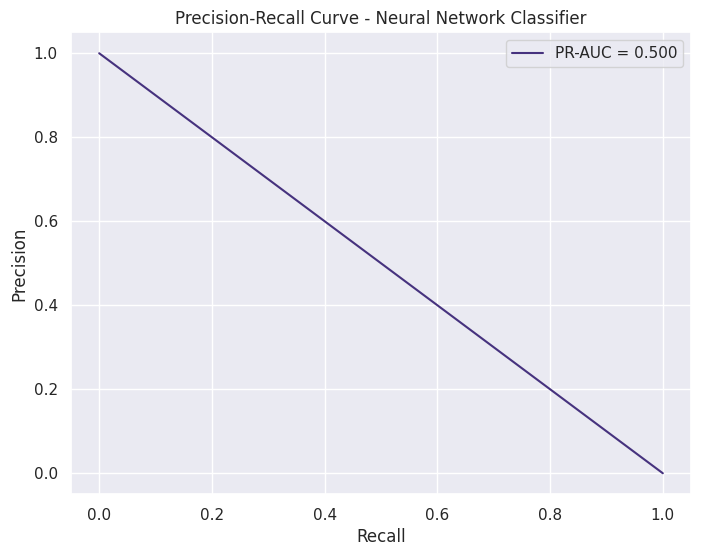

In [139]:
print("\nEvaluating on test set...")

recon_errors = np.mean(np.power(X_test - autoencoder.predict(X_test), 2), axis=1)
threshold = np.percentile(recon_errors[y_test == 0], 95)
recon_pred = (recon_errors > threshold).astype(int)

class_pred = (classifier.predict(X_test) > 0.5).astype(int).flatten()

print("\nAutoencoder Reconstruction-based Results:")
print(classification_report(y_test, recon_pred))
print("PR-AUC:", average_precision_score(y_test, recon_errors))

print("\nNeural Network Classifier Results:")
print(classification_report(y_test, class_pred))
print("ROC-AUC:", roc_auc_score(y_test, classifier.predict(X_test)))
print("PR-AUC:", average_precision_score(y_test, classifier.predict(X_test)))

precision, recall, _ = precision_recall_curve(y_test, classifier.predict(X_test))
pr_auc = auc(recall, precision)
plt.figure(figsize=(8,6))
plt.plot(recall, precision, label=f'PR-AUC = {pr_auc:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Neural Network Classifier')
plt.legend()
plt.grid(True)
plt.savefig('pr_curve_nn.png')
plt.show()

In [140]:
classifier.save('best_fraud_nn_model.keras')
joblib.dump(scaler,'scaler.pkl')

print("\nNeural Network model saved → ready for bank transaction interface")
print("Done!")


Neural Network model saved → ready for bank transaction interface
Done!


In [142]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,Amount_scaled,Time_scaled
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.0,0.335536,-1.687738
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0.0,-0.272718,-1.687738
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0.0,1.283705,-1.685521
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.0,0.227405,-1.685521
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0.0,0.005887,-1.683303
